# Cargar los datos

In [4]:
df = pd.read_csv('/kaggle/input/estudiantes/estudiantes.csv')

df.head()
#print(df.shape)

,escuela,sexo,edad,direccion,tamano_familia,estatus_padres,educacion_madre,educacion_padre,trabajo_madre,trabajo_padre,...,calidad_relaciones_familiares,tiempo_libre,salidas,consume_alc_entre_semana,consume_alc_fin_semana,salud,ausencias,P1,P2,P3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


# Preparar los datos

In [5]:
#Eliminar filas con valores nulos, esto es opcional ya que mejor lo remplazamos por ceros
#df= df.dropna()

#verificar que los tipos de datos de cada columna sean correcto
#tipos_de_dato = df.dtypes
#print(tipos_de_dato)

#Hacer que la codificacion este correcta para que no haya errores de caracteres.
# Convertir todas las celdas del DataFrame a UTF-8
#data_frame = data_frame.applymap(lambda x: x.encode('latin-1').decode('utf-8', 'ignore'))

# Encontrar registros con todos los valores duplicados
#duplicados_completos = df[df.duplicated(df.columns, keep=False)]

#Imprimir los registros completos duplicados si los hay
#if not duplicados_completos.empty:
  #  print("SI HAY:")
#else:
  #  print("No hay registros con todos los valores iguales en el DataFrame.")
    
# Eliminar registros duplicados del DataFrame
#data_frame_sin_duplicados = data_frame.drop_duplicates()
# Imprimir información sobre la cantidad de registros eliminados
#registros_duplicados_elim = len(data_frame) - len(data_frame_sin_duplicados)
#print("Se eliminaron {} registros duplicados del DataFrame.".format(registros_duplicados_elim))
#data_frame = data_frame_sin_duplicados

#Remplazar valores nulos de registros por 0
#data_frame.fillna(0, inplace=True)
#Verificar si hay alguna celda nula en el DataFrame
#hay_nulos = df.isnull().any()
#if hay_nulos.any():
 #   print("Hay al menos una celda nula en el DataFrame.")
#else:
 #   print("No hay celdas nulas en el DataFrame.")

# Agregar columna estatus
esta columna marca un reprobado si en algun parcial el alumno saco menos del minimo aprobatorio (14)

In [8]:
#hola mundo
# Añadir la columna 'estatus'
df['estatus'] = df.apply(lambda row: '1' if row['P1'] < 14 or row['P2'] < 14 or row['P3'] < 14 else '0', axis=1)

# Modelo

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 139.4600 - val_loss: 134.1340
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 138.5993 - val_loss: 126.6526
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 130.1904 - val_loss: 121.3591
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 122.3111 - val_loss: 117.0896
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 115.5050 - val_loss: 113.2406
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 118.8552 - val_loss: 109.3926
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 115.1607 - val_loss: 105.2297
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 109.7084 - val_loss: 100.4822
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 101.2443 - val_loss: 95.2285
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 109.6163 - val_loss: 89.4117
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 92.8247 - val_loss: 83.0195
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms

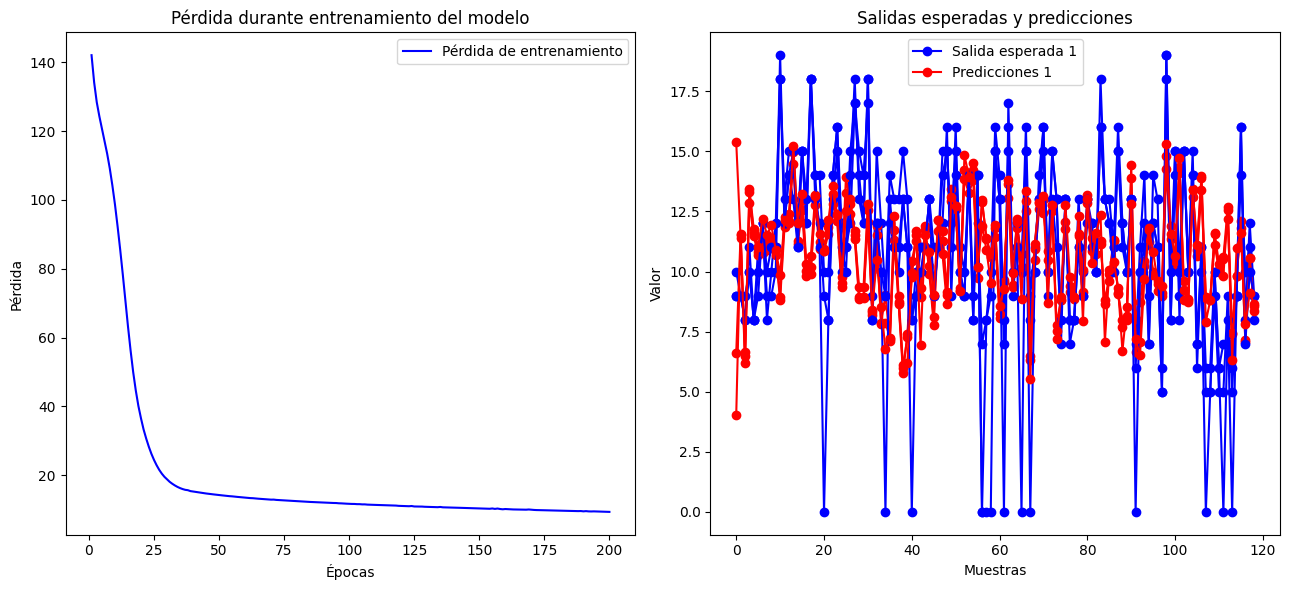

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Nueva predicción continuas: [[13.292765 13.838046 14.116549]]


In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Dense # type: ignore
from tensorflow.keras.models import Model # type: ignore

epocas = 200
entrenamiento = 0.70
size = [13, 6]

entradas = ['direccion', 'tamano_familia', 'estatus_padres', 'educacion_madre', 'educacion_padre','trabajo_madre','trabajo_padre','razon_escuela','traslado_escuela','tiempo_estudio','reprobacion','apoyo_educativo_adicional','apoyo_educativo_familiar','clases_extra_pagas','actividades_extracurriculares','asistio_guarderia','quiere_educacion_superior','internet','en_relacion_romantica','calidad_relaciones_familiares','tiempo_libre','salidas','consume_alc_entre_semana','consume_alc_fin_semana','salud','ausencias']

# Codificar las columnas categóricas a valores numéricos
label_encoders = {}
for column in entradas:
    if df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

 #Preparar los datos de entrada y salida
datos_entrada = df[entradas].values
datos_salida = df[['P1', 'P2', 'P3']].values

# Dividir los datos en Training set y Validation set
cantidad_datos = len(df)
entrenamiento = int(cantidad_datos * entrenamiento)

training_input = datos_entrada[:entrenamiento]
training_output = datos_salida[:entrenamiento]
validation_input = datos_entrada[entrenamiento:]
validation_output = datos_salida[entrenamiento:]

# Convertir los valores a tensores
train_inputs = tf.convert_to_tensor(training_input, dtype=tf.float32)
train_outputs = tf.convert_to_tensor(training_output, dtype=tf.float32)
val_inputs = tf.convert_to_tensor(validation_input, dtype=tf.float32)
val_outputs = tf.convert_to_tensor(validation_output, dtype=tf.float32)

# Definir el modelo
input_layer = Input(shape=(len(entradas),))
hidden_layer = Dense(16, activation='relu')(input_layer)
hidden_layer = Dense(8, activation='relu')(hidden_layer)
output_layer = Dense(3, activation='linear')(hidden_layer)  # tres salidas lineales

model = Model(inputs=input_layer, outputs=output_layer)

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo con datos de entrenamiento y validación
history = model.fit(train_inputs, train_outputs, epochs=epocas, validation_split=0.2, batch_size=32, verbose=1)

# Evaluar el modelo con los datos de validación
loss = model.evaluate(val_inputs, val_outputs)
print(f'Loss en el conjunto de validación: {loss}')

# Predecir con nuevas entradas
predicciones = model.predict(val_inputs)

# Crear una figura y dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(size[0], size[1]))

# Obtener la pérdida del historial de entrenamiento
loss = history.history['loss']

# Graficar la pérdida en el primer subplot
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, 'b', label='Pérdida de entrenamiento')
ax1.set_title('Pérdida durante entrenamiento del modelo')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Pérdida')
ax1.legend()

# Graficar las salidas esperadas y las predicciones en el segundo subplot
for i in range(3):  # Iterar sobre las cuatro salidas (P1, P2, P3, estatus)
    ax2.plot(range(len(validation_output)), validation_output[:, i], 'bo-', label=f'Salida esperada {i+1}' if i == 0 else "")
    ax2.plot(range(len(predicciones)), predicciones[:, i], 'ro-', label=f'Predicciones {i+1}' if i == 0 else "")

ax2.set_title('Salidas esperadas y predicciones')
ax2.set_xlabel('Muestras')
ax2.set_ylabel('Valor')
ax2.legend()

# Ajustar los subplots para evitar solapamiento
plt.tight_layout()

# Mostrar la figura con los dos subplots
plt.show()


# Función para predecir con nuevos datos
def predecir_nuevo(direccion, tamano_familia, estatus_padres, educacion_madre, educacion_padre, trabajo_madre, trabajo_padre,
                   razon_escuela, traslado_escuela, tiempo_estudio, reprobacion, apoyo_educativo_adicional, apoyo_educativo_familiar,
                   clases_extra_pagas, actividades_extracurriculares, asistio_guarderia, quiere_educacion_superior, internet,
                   en_relacion_romantica, calidad_relaciones_familiares, tiempo_libre, salidas, consume_alc_entre_semana,
                   consume_alc_fin_semana, salud, ausencias):

    nuevo_dato = np.array([[direccion, tamano_familia, estatus_padres, educacion_madre, educacion_padre, trabajo_madre,
                            trabajo_padre, razon_escuela, traslado_escuela, tiempo_estudio, reprobacion, apoyo_educativo_adicional,
                            apoyo_educativo_familiar, clases_extra_pagas, actividades_extracurriculares, asistio_guarderia,
                            quiere_educacion_superior, internet, en_relacion_romantica, calidad_relaciones_familiares, tiempo_libre,
                            salidas, consume_alc_entre_semana, consume_alc_fin_semana, salud, ausencias]])

    # Codificar el nuevo dato
    for i, column in enumerate(entradas):
        if column in label_encoders:
            nuevo_dato[:, i] = label_encoders[column].transform(nuevo_dato[:, i])
    
    # Predecir con el nuevo dato
    prediccion = model.predict(nuevo_dato)
    return prediccion

# Ejemplo de predicción con un nuevo dato (puedes cambiar los valores según tu interés)
nueva_prediccion = predecir_nuevo(1, 2, 1, 3, 4, 2, 3, 1, 2, 2, 0, 0, 1, 0, 1, 0, 1, 1, 0, 4, 2, 3, 2, 3, 4, 6)
print('Nueva predicción continuas:', nueva_prediccion)